In [1]:
import os
import colorsys
import numpy as np
import random
import pandas as pd
from collections import defaultdict

from scipy.spatial import cKDTree

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import py3Dmol

from Bio.PDB import PDBIO, PDBParser, Select
from Bio.PDB.Chain import Chain
from Bio.PDB.Residue import Residue

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

# This notebook summarizes the analysis of several Ebola glycoprotein trimer structures

All steps are covered from structure preparation to clustering and visualisation

In [2]:
# list of the files for analysis
pdb_dirs = [x for x in os.listdir('.')]

files = []
for pdb_dir in pdb_dirs:
    if (not '.' in pdb_dir):
        row = [pdb_dir, pdb_dir.lower()]
        files.append(row)
files

[['5IQ7', '5iq7'],
 ['6G9I', '6g9i'],
 ['6F6N', '6f6n'],
 ['7LYD', '7lyd'],
 ['6OZ9', '6oz9'],
 ['5JQ3', '5jq3'],
 ['6NAE', '6nae']]

## Structure preprocessing

PDb files for Ebola GP are biological assemblies holding several states of one chain. In order to generate single-state trimer files, each PDB file was opened in PyMol and the states were split using the command:

```python
split_states file_name
```

Then only the trimer protein was saved without binding partners as `PDBid_protein.pdb`.

The following preparation process slightly varies from preparation of Spike protein trimers due to the fact that all chains in Spike files are named differently, while here files have 3 copies of the chains with identical names. So we have to rename them additionally.

### 1. Chain renumbering

In [34]:
for file, pdb_id in files:
    
    #############
    pdb_to_load = f'{file}/{pdb_id}_protein.pdb'
    pdb_intermediate = f'{file}/{pdb_id}_protein_cleaned.pdb'
    pdb_to_save = f'{file}/{pdb_id}_renumbered.pdb'
    #############
    
    # First, we will have to simplify the file and rename chains
    with open(pdb_to_load, 'r') as f:
        lines = f.readlines()

    chain_selection = ['G', 'F' , 'E', 'D', 'C', 'B', 'A']
    cur_chain = ''
    with open(pdb_intermediate, 'w') as f:
        for line in lines:
            if line.startswith('ATOM'):

                if (len(cur_chain) == 0) or \
                   (line[21] != cur_chain):
                    cur_chain = line[21]
                    cur_rename = chain_selection.pop()

                new_line = line[:21] + cur_rename + line[22:]
                f.write(new_line)

    # read structure with BioPython 
    io = PDBIO()
    parser = PDBParser()
    trimer_structure = parser.get_structure('trimer', pdb_intermediate)

    # renumber residues in trimer_structure
    last_A_res_id = 0
    renumbered_residues = []
    n_residues_renumbered = 0

    first_chain = ''
    for model in trimer_structure:
        for chain in model:

            if len(first_chain) == 0:
                first_chain = chain.id

            for residue in chain:

                if chain.id == first_chain:
                    last_A_res_id = residue.id[1]
                else:

                    if not (chain.id, residue.id) in renumbered_residues:
                        renumbered_residues.append((chain.id, residue.id))
                        n_residues_renumbered += 1

                    # change residue id
                    residue.id = (residue.id[0],
                                  last_A_res_id + n_residues_renumbered,
                                  residue.id[2])

    io.set_structure(trimer_structure)
    io.save(pdb_to_save,  preserve_atom_numbering=True) 

### 2. Clean disordered atoms

In [49]:
# for file, pdb_id in files:
for file, pdb_id in files:
    
    #############
    pdb_to_load = f'{file}/{pdb_id}_renumbered.pdb'
    pdb_to_save = f'{file}/{pdb_id}_renumbered.pdb'
    #############

    parser = PDBParser()
    s = parser.get_structure("structure", pdb_to_load)

    # keeps alt loc A and eliminates the loc ID
    class NotDisordered(Select):
        def accept_atom(self, atom):
            if (not atom.is_disordered()) or atom.get_altloc() == 'A':
                atom.set_altloc(" ")  # Eliminate alt location ID before output.
                return True
            else:  
                # Alt location was not one to be output.
                return False

    io = PDBIO()
    io.set_structure(s)
    io.save(pdb_to_save, select = NotDisordered())

**Then all chains in each structure were renamed to A in PyMol and saved as `PDBid_renumbered_chains_A.pdb` files**

## fpocket to check existing cavities

In this analysis we are not aligning the fpocket output data (as it was done in course of Spike protein analysis). Each output is simply inspected visually

In [7]:
# generate script for fpocket

cwd = os.getcwd()
with open('fpocket_runs.sh', 'w') as f:
    f.write("#!/bin/bash\n")
    f.write("\n")
    for file, pdb_id in files:
        f.write(f"cd {cwd}/{file}\n")
        f.write(f"fpocket -f {pdb_id}_renumbered_chains_A.pdb\n")
        f.write("\n")

## Read PocketMiner predictions and align everything

In [3]:
# read Ebola GP sequence to compare
EG_protein = ''
with open('EG_protein.fasta', 'r') as f:
    for line in f:
        if not line.startswith('>'):
            EG_protein += line.strip()
            
# convert into dictionary
EG_protein_residues = {i+1:EG_protein[i] for i in range(len(EG_protein))}

In [4]:
# dictionary to convert residue names to single letter
three_to_one_leter_name = {
                           "GLY": "G",
                           "ALA": "A",
                           "VAL": "V",
                           "LEU": "L",
                           "ILE": "I",
                           "SER": "S",
                           "THR": "T",
                           "MET": "M",
                           "CYS": "C",
                           "ASN": "N",
                           "GLN": "Q",
                           "ASP": "D",
                           "GLU": "E",
                           "LYS": "K",
                           "ARG": "R",
                           "HIS": "H", "HSD": "H", "HSE": "H", "HSP": "H",
                           "PHE": "F",
                           "TRP": "W",
                           "TYR": "Y",
                           "PRO": "P",
                           }

Exctraction of protein sequences from each file subjected to analysis:

In [5]:
# read data from each file
sequences = []
for file, pdb_id in files:
    parser = PDBParser()
    trimer_structure = parser.get_structure('trimer',
                                            f"{file}/{pdb_id}_renumbered.pdb")

    sequence = ''
    for model in trimer_structure:
        for chain in model:
            
            if chain.id in ['A', 'B']:
                for residue in chain:
                    if not residue.get_resname() == 'UNK':
                        sequence += three_to_one_leter_name[residue.get_resname()]

    sequences.append([file, sequence])

# save all of that into fasta
with open('EG_sequences.fasta', 'w') as f:
    f.write(">reference\n")
    f.write(f"{EG_protein}\n")
    for seq in sequences:
        f.write(f">{seq[0]}\n")
        f.write(f"{seq[1]}\n")

These sequences were aligned in in UGENE software using MUSCLE algorithm with default options. Then the alignment was inspected manually and saved as FASTA file

In [6]:
# read aligned sequences from FASTA file
aligned_sequences = {}
with open('EG_sequences_aligned.fa', 'r') as f:
    seq = ''
    for line in f:
        if line.startswith('>'):
            if len(seq) > 0:
                aligned_sequences[name] = seq
                seq = ''  
            name = line.strip()[1:]
        else:
            seq += line.strip()
            
    if len(seq)> 0:
        aligned_sequences[name] = seq

**Now we are ready to organise data into matrix**

In [53]:
# matrix to collect data on residue pribabilities
# -1 will correspond to the residues without any probability
PocketMiner_data = np.zeros(((len(aligned_sequences) - 1) * 3, len(EG_protein)))
PocketMiner_data[:,:] = -1
PocketMiner_data_index = []


# collect data from each file
row = 0 # row index for PM data matrix
for file, pdb_id in files:
    
    print('Processing: ', file, pdb_id)
    
    # read PocketMiner data
    PM_data = []
    PM_res_inds = []
    with open(f'{file}/{pdb_id}_PocketMiner.pdb', 'r') as f:
        for line in f:
            if "ATOM" in line:
                data = line.split()
                res_prob = float(data[-2])
                try:
                    res_name = three_to_one_leter_name[data[3]]
                except:
                    print(file)
                    raise Exception
                res_id = int(data[5]) if len(data[4]) == 1 else int(data[4][1:])
                if res_id not in PM_res_inds:
                    PM_res_inds.append(res_id)
                    PM_data.append((res_prob, res_name))

    # get aligned sequence
    seq_aligned = aligned_sequences[file]
    
    # get unaligned seq
    seq_unaligned = seq_aligned.replace('-', '')
    
    # get matrix indices of the residues
    res_indices, res_to_skip = [], []
    for k, (res, ref_res) in enumerate(zip(seq_aligned, EG_protein)):
        if res != '-':
            res_indices.append(k)
        ##########################
        if res != ref_res:
            res_to_skip.append(k)
        ##########################
        
    # now relate PM data to aligned sequences
    i = 0 # sequential index of residue
    for k in range(3):
        
        # we are constructing this row now
        PocketMiner_data_index.append(f"{file}_{k+1}")
            
        for matrix_ind, res_name in zip(res_indices, seq_unaligned):    
            
            # for each residue record probability if its correct
            PM_prob, PM_res_name = PM_data[i]
            
            # sequence check
            if res_name != PM_res_name:                                       
                print(file, res_name, PM_data[i])
            # if sequence is alrigth add element to matrix
            else:
                if matrix_ind not in res_to_skip:
                    PocketMiner_data[row, matrix_ind] = PM_prob
            
            i += 1
                        
        # row processed, switch to new row and check sequence
        row += 1

Processing:  5IQ7 5iq7
Processing:  6G9I 6g9i
Processing:  6F6N 6f6n
Processing:  7LYD 7lyd
Processing:  6OZ9 6oz9
Processing:  5JQ3 5jq3
Processing:  6NAE 6nae


In [56]:
# crop columns without any data

columns = [str(i) for i in range(1, PocketMiner_data.shape[1] + 1)]
min_col, max_col = 0, 0
encountered_non_empty = False
for i in range(PocketMiner_data.shape[1]):
    if sum(PocketMiner_data[:, i] != -1) > 0:
        if i > max_col:
            max_col = i
        encountered_non_empty = True
    else:
        if not encountered_non_empty:
            min_col = i
            
columns = columns[min_col+1:max_col + 1]
PocketMiner_data_cropped = PocketMiner_data[:, min_col+1:max_col + 1]

# save matrix
PocketMiner_df = pd.DataFrame(data=PocketMiner_data_cropped,
                              columns=columns,
                              index=PocketMiner_data_index)

PocketMiner_df.to_csv('PocketMiner_data.csv')
PocketMiner_df.to_excel('PocketMiner_data.xlsx')

In [8]:
# reload matrix
PocketMiner_df = pd.read_csv('PocketMiner_data.csv', index_col=0)
PocketMiner_df.head()

29   30   31    32    33    34    35    36    37    38  ...   623  \
5IQ7_1  0.87 -1.0 -1.0  0.91  0.90  0.87  0.82  0.28  0.64  0.76  ...  0.54   
5IQ7_2  0.89 -1.0 -1.0  0.88  0.89  0.84  0.83  0.30  0.65  0.77  ...  0.49   
5IQ7_3  0.88 -1.0 -1.0  0.85  0.88  0.81  0.79  0.29  0.61  0.77  ...  0.59   
6G9I_1 -1.00 -1.0 -1.0  0.84  0.90  0.73  0.82  0.32  0.61  0.72  ...  0.59   
6G9I_2 -1.00 -1.0 -1.0  0.63  0.80  0.64  0.80  0.32  0.63  0.72  ...  0.53   

         624   625   626   627   628   629   630   631   632  
5IQ7_1  0.43  0.33  0.53  0.67  0.37  0.22  0.62  0.38  0.21  
5IQ7_2  0.33  0.20  0.48  0.66  0.40  0.16  0.59  0.30  0.16  
5IQ7_3  0.23  0.31  0.60  0.69  0.32  0.22  0.69  0.35  0.22  
6G9I_1  0.36  0.34  0.49  0.65  0.36  0.19  0.49  0.27 -1.00  
6G9I_2  0.28  0.25  0.47  0.57  0.30  0.14  0.55  0.29 -1.00  

[5 rows x 604 columns]

<AxesSubplot:>

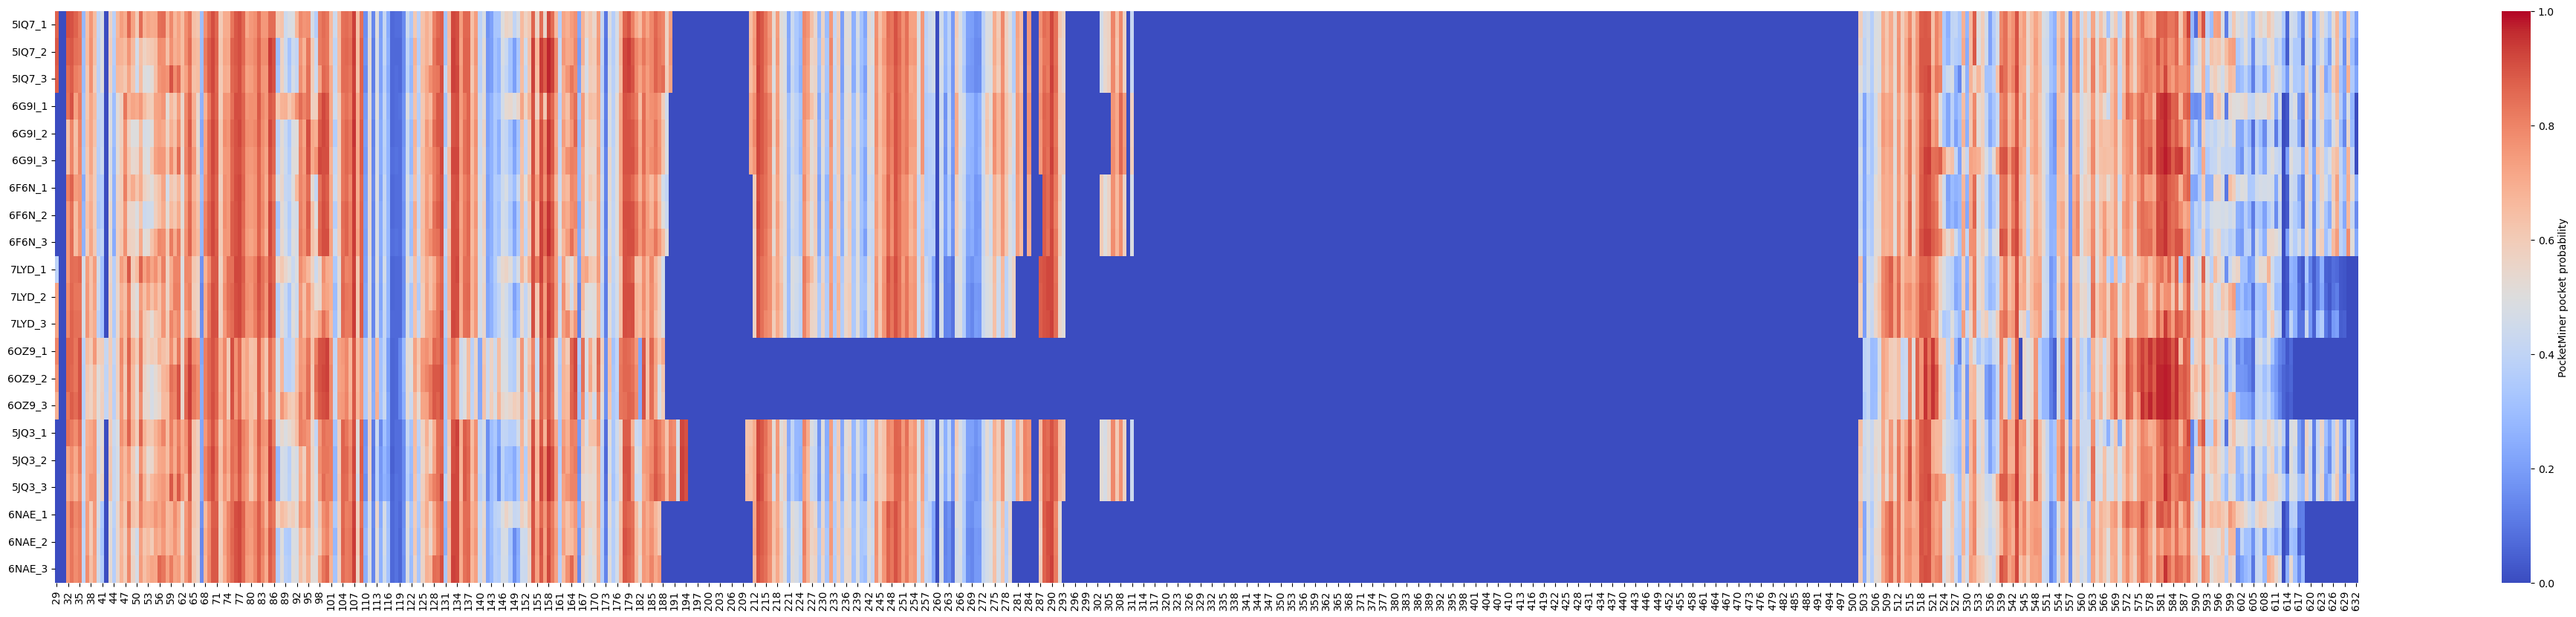

In [9]:
# visualise matrix
plt.figure(figsize=(50, 10))
sns.heatmap(PocketMiner_df,
            vmin=0, vmax=1,
            cmap='coolwarm',
            cbar_kws={'label': 'PocketMiner pocket probability'})

We can clearly see how some spans are missing. Especially big gap corresponds to mucin-like domain

## Visualise Pocket Miner predictions

In [10]:
def prob_to_color(prob):
    if prob > 0.5:
        rgb = colorsys.hsv_to_rgb(0, (2*prob) - 1, 1)
    else:
        rgb = colorsys.hsv_to_rgb(0.55, (2*(1 - prob)) - 1, 1)

    return {'r': rgb[0], 'g': rgb[1], 'b': rgb[2]}


def VisPocketMiner(file, prob_threshold=0.0, dim=(600,600)):
    
    # read system from PDB file
    with open(file,'r') as ifile:
        system = "".join([x for x in ifile])

    # generate view
    view = py3Dmol.view(width=dim[0], height=dim[1])
    view.addModelsAsFrames(system)
    view.setStyle({'model': -1}, {"cartoon": {'color': {'r': 0.95, 'g': 0.95, 'b': 0.95}}})
    
    # color each atom according to probability
    for i, line in enumerate(system.split("\n")):

        data = line.split()
        if len(data) == 0 or data[0] != "ATOM":
            continue

        prob = float(data[-2])
        if prob > prob_threshold:
            color = prob_to_color(prob)
            view.setStyle({'model': -1, 'serial': i + 1},
                          {"cartoon": {'color': color}})

    view.zoomTo()

    return view

In [11]:
structure_to_visualise = '5JQ3'
file = f"{structure_to_visualise}/{structure_to_visualise.lower()}_PocketMiner.pdb"

view = VisPocketMiner(file)
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Density-based clustering

In [12]:
# Euclidian distance modifyed to account for probabilities 
def EuclideanWeighted(x, y):
    p = 1 / (x[-1] + y[-1])**2
    d = np.sqrt(sum((x[:-1] - y[:-1])**2))
    return  p * d

# function to load data on residues
def LoadResidueData(files, prob_threshold = 0.8):

    # we will collect data here
    data_for_PCA = {}

    # read residue coordinates with probabilities
    residues = defaultdict(list)
    residues_properties = {}
    with open(file, 'r') as f:
        for line in f:
            if "ATOM" in line:
                data = line.split()

                res_prob = float(data[-2])
                coords = [float(data[-6]), float(data[-5]), float(data[-4])]
                res_id = int(data[5]) if len(data[4]) == 1 else int(data[4][1:])

                if res_prob > prob_threshold:
                    residues[res_id].append(coords)
                    residues_properties[res_id] = res_prob

    # calculate centroids for each residue
    for res_id in residues:
        residues[res_id] = np.array(residues[res_id]).mean(axis=0)

    # create data matrix 
    matrix = []
    for res_id in residues:
        new_row = list(residues[res_id])
        new_row.append(residues_properties[res_id])
        matrix.append(new_row)

    res_ids   = [i for i in residues] 
    res_probs = [residues_properties[i] for i in residues]

    data_for_PCA = {
        'data' : np.array(matrix),
        'labels' : res_ids,
        'probs' : res_probs
    }

    return data_for_PCA

# load atom indicies for each residue
def load_atoms_per_residue(file):
    
    res_atoms = defaultdict(list)
    
    atom_ind = 1
    with open(file, 'r') as f:
        for line in f:
            if "ATOM" in line:
                data = line.split()
                res_id = int(data[5]) if len(data[4]) == 1 else int(data[4][1:])
                res_atoms[res_id].append(atom_ind)
                atom_ind += 1
    
    return res_atoms

# visualise clusers on structure
def VisClusters(file, clusters, atoms_per_res, dim=(500,500)):
    
    # read system from PDB file
    with open(file,'r') as ifile:
        system = "".join([x for x in ifile])

    # generate view
    view = py3Dmol.view(width=dim[0], height=dim[1])
    view.addModelsAsFrames(system)
    view.setStyle({'model': -1}, {"cartoon": {'color': {'r': 0.9, 'g': 0.9, 'b': 0.9}}})
    
    # generate colors for each cluster
    colors =  sns.color_palette(None, len(clusters))         
    
    # color each atom according to probability
    for color, lab in zip(colors, clusters.keys()):
        r, g, b = color
        # color each atom in each residue belonging to the cluster
        for res in clusters[lab]:
            for i in atoms_per_res[res]:
                view.setStyle({'model': -1, 'serial': i},
                              {"cartoon": {'color': {'r': r, 'g': g, 'b': b}}})

    view.zoomTo()

    return view

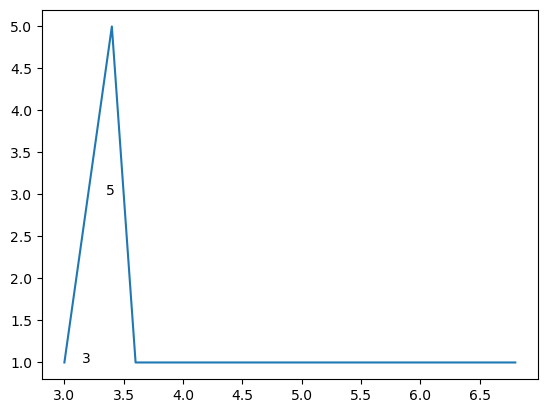

In [13]:
structure_to_visualise = '5JQ3'
file = f"{structure_to_visualise}/{structure_to_visualise.lower()}_PocketMiner.pdb"

# load PM data for clustering
residue_data = LoadResidueData(file,
                               prob_threshold=0.5)

# here are different hyperparameter lists attempted for this analysis
# epsilons = np.arange(3.0, 5.2, 0.2) # epsilons for min sample 10
# epsilons = np.arange(5.4, 7.2, 0.2) # epsilons for min sample 20
epsilons = np.arange(3.0, 7.0, 0.2) # epsilons for min sample 20 and squared prob normaliser

results, lab_count_list = [], []
for epsilon in epsilons:
    
    clusterer = DBSCAN(eps=epsilon,
                       min_samples=20,
                       metric=EuclideanWeighted)

    clusterer.fit(residue_data['data'])

    labels = clusterer.labels_
    
    no_clusters = len(np.unique(labels)) - 1 # we dont count noise labels
    no_noise = np.sum(np.array(labels) == -1, axis=0)
    
    # count number of residues in each cluster
    labs = np.unique(labels)
    lab_counts = []
    for lab in labs:
        if lab != -1:
            lab_counts.append(np.count_nonzero(labels == lab))
    
    results.append([no_clusters, no_noise])
    lab_count_list.append(lab_counts)
    
results = np.array(results)

fig, ax = plt.subplots()
ax.plot(epsilons, results[:, 0])

for i, txt in enumerate(results[:, 0]):
    ax.annotate(txt, (epsilons[i]-0.05, results[:, 0][i]-2))

In [25]:
####### visualise #########

# load PM data for clustering
residue_data = LoadResidueData(file,
                               prob_threshold=0.5)

# cluster 
clusterer = DBSCAN(eps=3.2,
                   min_samples=20,
                   metric=EuclideanWeighted)

clusterer.fit(residue_data['data'])
labels = clusterer.labels_ # get labels for each point
unique_labs = np.unique(labels)[1:] # get labels without the noise points
print(f"Discovered {len(unique_labs)} clusters")

# get residue indices for each cluster
res_inds = np.array(residue_data['labels'])
clusters = {}
for lab in unique_labs:
    mask = (labels == lab)
    clusters[lab] = res_inds[mask]
    
atoms_per_res = load_atoms_per_residue(file)

view =  VisClusters(file, clusters, atoms_per_res)
view.show()                

Discovered 3 clusters


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [61]:
# get lists of residues and average PM probabilities for these clusters

# read residue IDs, names and probabilities
residues = [] # [id, name, PM prob]
unique_res_id = []
prob_mask = []
with open(file, 'r') as f:
    for line in f:
        if "ATOM" in line:
            data = line.split()

            res_prob = float(data[-2])
            res_name = data[3][0] + data[3][1:].lower()
            res_id = int(data[5]) if len(data[4]) == 1 else int(data[4][1:])
            res_prob = float(data[-2])
            
            if not res_id in unique_res_id:
                unique_res_id.append(res_id)
                residues.append([res_id, res_name, res_prob])
                
                if res_prob > 0.5:
                    prob_mask.append(True)
                else:
                    prob_mask.append(False)
                    
residues = np.array(residues)
prob_mask = np.array(prob_mask)
clustered_residues = residues[prob_mask, :]
first_chain = residues.reshape((3, -1, 3))[0]

# show data for each of the clusters
for lab in unique_labs:
    
    cluster_mask = (labels == lab)
    cluster = clustered_residues[cluster_mask, :]
    
    av_prob = cluster[:, 2].astype(float).mean()
    
    print(f"Cluster {lab}, {cluster.shape[0]} residues, average probability {round(av_prob, 2)}")
    
    # print residue list
    cluster_residues = []
    cluster_residues_ids = []
    for res in cluster:
        structure_index = np.where(residues[:, 0] == res[0])[0][0]
        first_chain_index = structure_index - (lab * (residues.shape[0] // 3))
        first_chain_res = first_chain[first_chain_index, :]
        cluster_residues.append(first_chain_res[1] + first_chain_res[0])
        cluster_residues_ids.append(first_chain_res[0])
    print(', '.join(cluster_residues))   
    print('+'.join(cluster_residues_ids))   
    print()
    

Cluster 0, 36 residues, average probability 0.81
Leu68, Asn69, Leu70, Glu71, Gly72, Asn73, Gly74, Val75, Ala76, Thr77, Asp78, Val79, Ser81, Ala82, Arg85, Ala105, Glu106, Asn107, Cys108, Tyr109, Cys135, Arg136, Tyr137, Val138, His139, His154, Glu156, Ala158, Glu178, Gly179, Val180, Thr249, Pro250, Ala289, Phe290, Asn540
68+69+70+71+72+73+74+75+76+77+78+79+81+82+85+105+106+107+108+109+135+136+137+138+139+154+156+158+178+179+180+249+250+289+290+540

Cluster 1, 40 residues, average probability 0.83
Leu68, Asn69, Leu70, Glu71, Gly72, Asn73, Gly74, Val75, Ala76, Thr77, Asp78, Val79, Ser81, Ala82, Arg85, Trp86, Ala105, Glu106, Asn107, Tyr109, Cys135, Arg136, Tyr137, Val138, His139, His154, Glu156, Ala158, Phe159, Phe160, Ala177, Glu178, Gly179, Val180, Thr249, Pro250, Ala289, Phe290, Arg536, Asn540
68+69+70+71+72+73+74+75+76+77+78+79+81+82+85+86+105+106+107+109+135+136+137+138+139+154+156+158+159+160+177+178+179+180+249+250+289+290+536+540

Cluster 2, 33 residues, average probability 0.83
Leu